In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the datasets
locations_df = pd.read_csv('/Users/harshgarg/Projects/DAFZ/Wellington Hackaton/Hackathon_Challenge_Notebooks/Challenge2_Routing/data/delivery_locations.csv')
distance_matrix_df = pd.read_csv('/Users/harshgarg/Projects/DAFZ/Wellington Hackaton/Hackathon_Challenge_Notebooks/Challenge2_Routing/data/distance_traffic_matrix.csv')
orders_df = pd.read_csv('/Users/harshgarg/Projects/DAFZ/Wellington Hackaton/Hackathon_Challenge_Notebooks/Challenge2_Routing/data/delivery_orders.csv')

# Create a new feature for travel time (base_time_min * traffic_multiplier)
distance_matrix_df['travel_time'] = distance_matrix_df['base_time_min'] * distance_matrix_df['traffic_multiplier']

# Filter for distances from DEPOT to each location
depot_to_locations = distance_matrix_df[distance_matrix_df['from_location_id'] == 'DEPOT']

# Merge with locations to get coordinates along with distance and travel time
locations_with_features = pd.merge(
    locations_df, 
    depot_to_locations[['to_location_id', 'distance_km', 'travel_time']], 
    left_on='location_id', 
    right_on='to_location_id'
)

# Extract features for clustering
features = locations_with_features[['latitude', 'longitude', 'distance_km', 'travel_time']].values

# Scale the features to have equal importance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN clustering
# We'll need to tune eps and min_samples based on the scaled feature space
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='euclidean')
clusters = dbscan.fit_predict(features_scaled)

# Add cluster labels to the dataframe
locations_with_features['cluster'] = clusters


In [2]:
from scipy.spatial.distance import pdist, squareform

# Function to calculate a custom distance that combines geographic and time-based distances
def custom_distance(a, b, w_dist=0.5, w_time=0.5):
    """
    Calculate a weighted distance between two points considering both 
    geographic distance and travel time.
    
    Parameters:
    a, b: Arrays with [lat, lon, distance_km, travel_time]
    w_dist: Weight for the distance component
    w_time: Weight for the travel time component
    """
    # Geographic distance (using Haversine or Euclidean)
    lat1, lon1 = a[0], a[1]
    lat2, lon2 = b[0], b[1]
    geo_dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)  # Simple Euclidean for demonstration
    
    # Travel time difference
    time_diff = abs(a[3] - b[3])
    
    # Weighted combination
    return w_dist * geo_dist + w_time * time_diff

# Extract coordinates, distance, and travel time
points = locations_with_features[['latitude', 'longitude', 'distance_km', 'travel_time']].values

# Calculate the distance matrix using our custom metric
distance_matrix = squareform(pdist(points, lambda u, v: custom_distance(u, v)))

# Apply DBSCAN with the custom distance matrix
dbscan_custom = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
clusters_custom = dbscan_custom.fit_predict(distance_matrix)

# Add custom cluster labels to the dataframe
locations_with_features['cluster_custom'] = clusters_custom


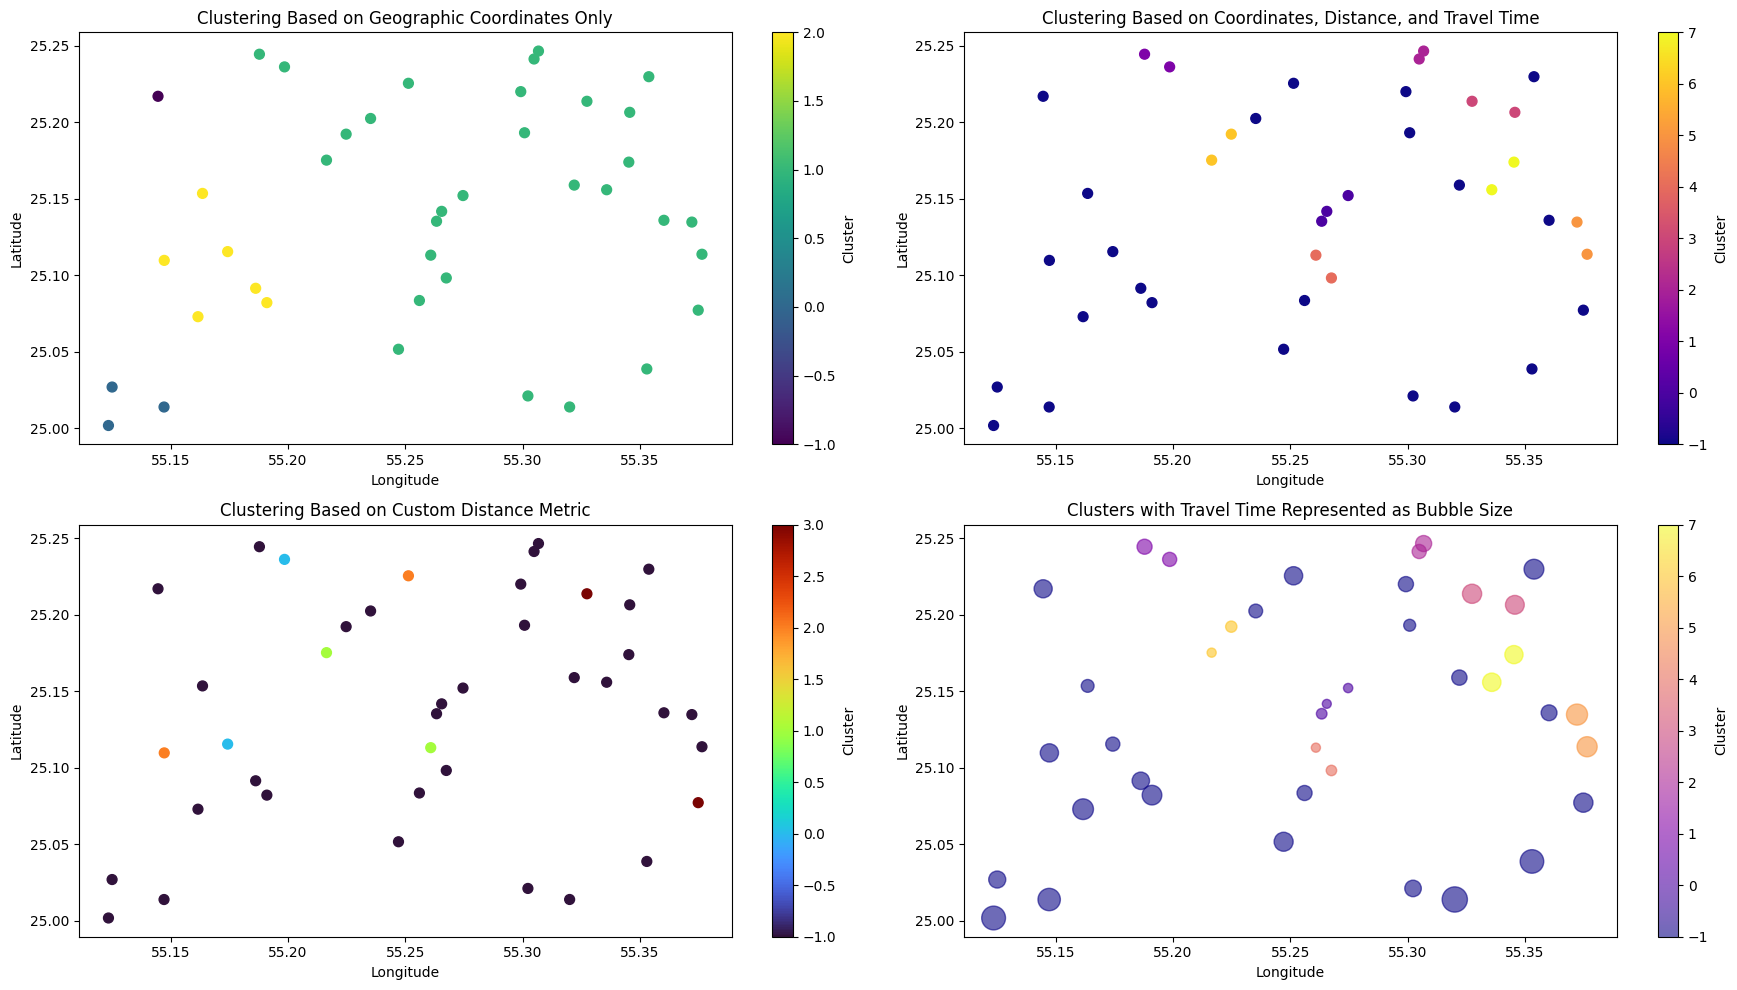

In [ ]:
# Create a figure with multiple subplots
plt.figure(figsize=(18, 10))

# Plot 1: Original locations colored by geographic coordinates only
plt.subplot(2, 2, 1)
geo_only_dbscan = DBSCAN(eps=0.05, min_samples=2).fit(
    locations_with_features[['latitude', 'longitude']].values
)
plt.scatter(
    locations_with_features['longitude'], 
    locations_with_features['latitude'], 
    c=geo_only_dbscan.labels_,
    cmap='viridis', 
    s=50
)
plt.title('Clustering Based on Geographic Coordinates Only')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Plot 2: Clustering with distance and travel time features
plt.subplot(2, 2, 2)
scatter = plt.scatter(
    locations_with_features['longitude'], 
    locations_with_features['latitude'], 
    c=clusters,
    cmap='plasma', 
    s=50
)
plt.title('Clustering Based on Coordinates, Distance, and Travel Time')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Plot 3: Clustering with custom distance metric 
plt.subplot(2, 2, 3)
scatter = plt.scatter(
    locations_with_features['longitude'], 
    locations_with_features['latitude'], 
    c=clusters_custom,
    cmap='turbo', 
    s=50
)
plt.title('Clustering Based on Custom Distance Metric')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

# Plot 4: Bubble chart showing travel time as bubble size
plt.subplot(2, 2, 4)
scatter = plt.scatter(
    locations_with_features['longitude'], 
    locations_with_features['latitude'], 
    c=clusters,
    s=locations_with_features['travel_time'] * 5,  # Scale bubble size by travel time
    alpha=0.6,
    cmap='plasma'
)
plt.title('Clusters with Travel Time Represented as Bubble Size')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()


   eps  n_clusters  n_noise_points              cluster_sizes
0  0.1           0              40                         []
1  0.2           0              40                         []
2  0.3           1              37                        [3]
3  0.4           2              35                     [3, 2]
4  0.5           8              23   [3, 2, 2, 2, 2, 2, 2, 2]
5  0.6           7              22      [3, 2, 2, 4, 2, 2, 3]
6  0.7           8              15   [5, 5, 2, 2, 3, 3, 3, 2]
7  0.8           8              14   [5, 5, 2, 3, 3, 3, 3, 2]
8  0.9           8               6  [2, 11, 5, 2, 6, 2, 3, 3]
9  1.0           6               3        [2, 21, 2, 7, 2, 3]


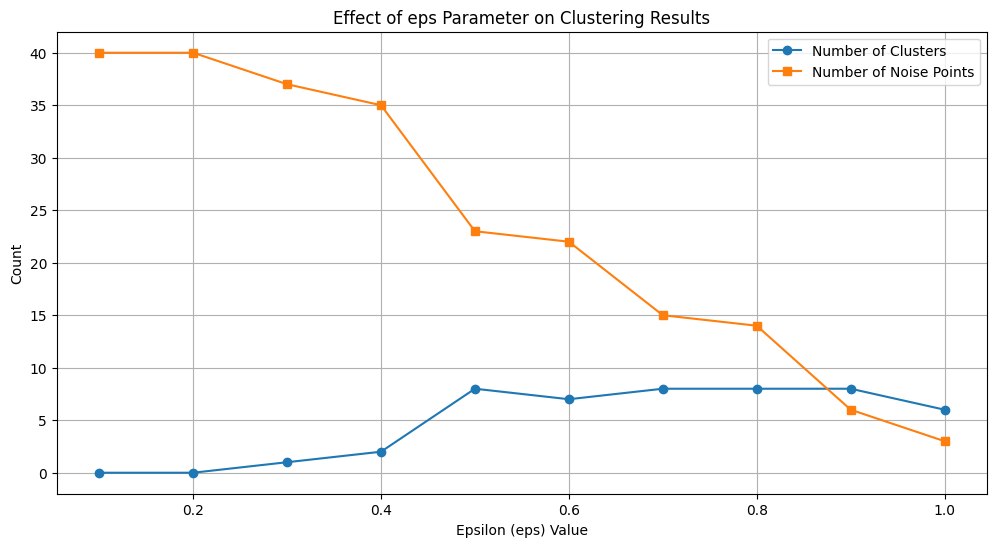

In [4]:
# Function to evaluate different eps values
def evaluate_eps_values(X, min_samples=2, eps_range=np.arange(0.1, 1.1, 0.1)):
    results = []
    
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)
        
        # Count number of clusters (excluding noise with label -1)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise_points': n_noise,
            'cluster_sizes': [list(clusters).count(i) for i in range(n_clusters)]
        })
    
    return pd.DataFrame(results)

# Evaluate different eps values for our scaled features
eps_evaluation = evaluate_eps_values(features_scaled)
print(eps_evaluation)

# Plot the number of clusters and noise points for different eps values
plt.figure(figsize=(12, 6))
plt.plot(eps_evaluation['eps'], eps_evaluation['n_clusters'], 'o-', label='Number of Clusters')
plt.plot(eps_evaluation['eps'], eps_evaluation['n_noise_points'], 's-', label='Number of Noise Points')
plt.xlabel('Epsilon (eps) Value')
plt.ylabel('Count')
plt.title('Effect of eps Parameter on Clustering Results')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
class AdaptiveDeliveryClustering:
    def __init__(self, eps=0.5, min_samples=2, w_dist=0.5, w_time=0.5):
        self.eps = eps
        self.min_samples = min_samples
        self.w_dist = w_dist
        self.w_time = w_time
        self.scaler = StandardScaler()
        self.model = None
        
    def fit(self, locations_df, distance_matrix_df):
        # Filter for depot distances and create travel time feature
        depot_distances = distance_matrix_df[distance_matrix_df['from_location_id'] == 'DEPOT'].copy()
        depot_distances['travel_time'] = depot_distances['base_time_min'] * depot_distances['traffic_multiplier']
        
        # Merge with locations
        self.data = pd.merge(
            locations_df,
            depot_distances[['to_location_id', 'distance_km', 'travel_time']],
            left_on='location_id',
            right_on='to_location_id'
        )
        
        # Scale features
        features = self.data[['latitude', 'longitude', 'distance_km', 'travel_time']].values
        self.features_scaled = self.scaler.fit_transform(features)
        
        # Fit DBSCAN
        self.model = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.data['cluster'] = self.model.fit_predict(self.features_scaled)
        
        return self.data['cluster']
    
    def update_clusters(self, new_locations_df, updated_distance_matrix_df):
        """Update clusters with new location data or updated traffic information"""
        # Combine existing and new data
        combined_locations = pd.concat([
            self.data[['location_id', 'address', 'latitude', 'longitude']],
            new_locations_df
        ]).drop_duplicates(subset=['location_id'])
        
        # Re-fit the model with updated data
        return self.fit(combined_locations, updated_distance_matrix_df)
    
    def visualize_clusters(self):
        """Visualize the current clustering"""
        plt.figure(figsize=(12, 8))
        
        # Plot clusters
        scatter = plt.scatter(
            self.data['longitude'],
            self.data['latitude'],
            c=self.data['cluster'],
            cmap='viridis',
            s=self.data['travel_time'] * 3,
            alpha=0.7
        )
        
        # Add location IDs as labels
        for i, row in self.data.iterrows():
            plt.annotate(
                row['location_id'],
                (row['longitude'], row['latitude']),
                fontsize=8
            )
        
        plt.colorbar(scatter, label='Cluster')
        plt.title('Delivery Locations Clustered by Distance and Travel Time')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.grid(True, alpha=0.3)
        
        return plt


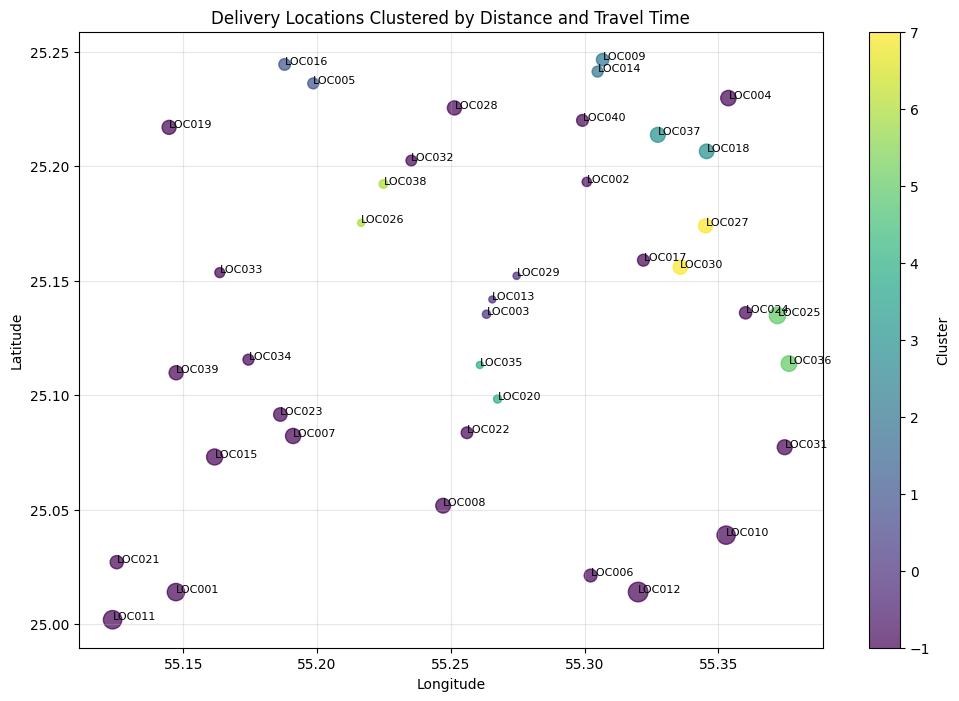

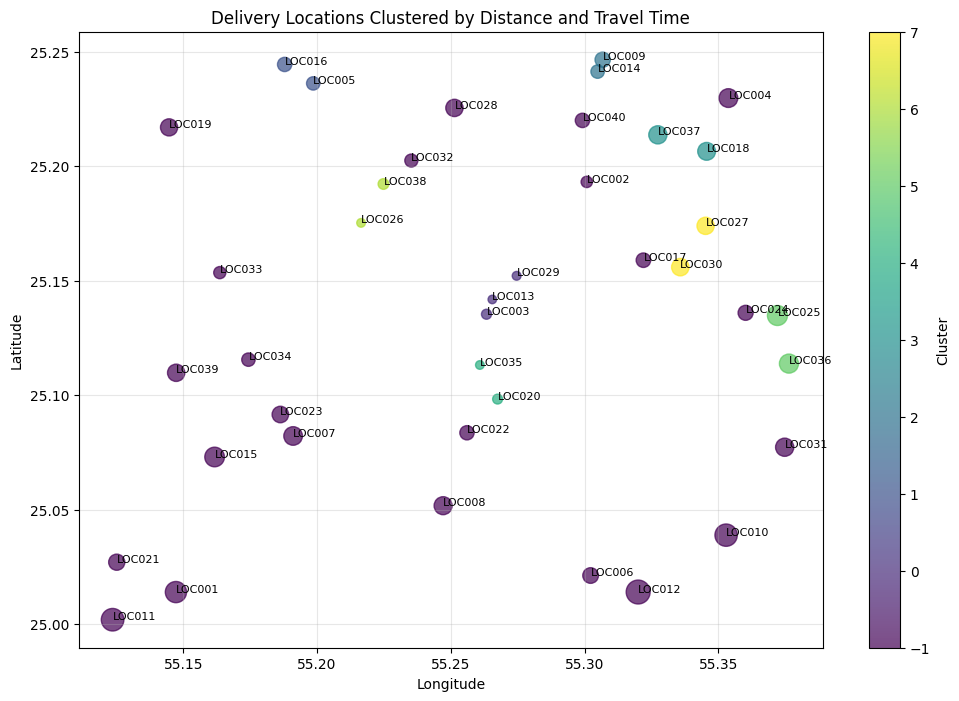

In [6]:
# Initialize the clustering model
delivery_clustering = AdaptiveDeliveryClustering(
    eps=0.5,
    min_samples=2,
    w_dist=0.6,  # Give slightly more weight to distance
    w_time=0.4   # And less weight to travel time
)

# Fit the initial model
clusters = delivery_clustering.fit(locations_df, distance_matrix_df)

# Visualize the clusters
delivery_clustering.visualize_clusters()
plt.show()

# Later, when traffic conditions change or new orders arrive:
updated_distance_matrix = distance_matrix_df.copy()
# Update traffic multipliers based on current time of day
updated_distance_matrix.loc[updated_distance_matrix['from_location_id'] == 'DEPOT', 'traffic_multiplier'] *= 1.5  # Traffic increased by 50%

# Add new delivery locations
new_locations = pd.DataFrame({
    'location_id': ['LOC041', 'LOC042'],
    'address': ['New Address 1', 'New Address 2'],
    'latitude': [25.15, 25.22],
    'longitude': [55.28, 55.31]
})

# Update the clusters
updated_clusters = delivery_clustering.update_clusters(new_locations, updated_distance_matrix)

# Visualize the updated clusters
delivery_clustering.visualize_clusters()
plt.show()
